In [76]:
from tensorflow.python.keras import layers, models

# Data Preprocessing

In [77]:
#loading the dataset
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
df = pd.read_csv('./data/card_transdata.csv')

## Data Visualization

### Describtive Analysis

In [78]:
df.head()

,distance_from_home,distance_from_last_transaction,ratio_to_median_purchase_price,repeat_retailer,used_chip,used_pin_number,online_order,fraud
0,57.877857,0.311140,1.945940,1.0,1.0,0.0,0.0,0.0
1,10.829943,0.175592,1.294219,1.0,0.0,0.0,0.0,0.0
2,5.091079,0.805153,0.427715,1.0,0.0,0.0,1.0,0.0
3,2.247564,5.600044,0.362663,1.0,1.0,0.0,1.0,0.0
4,44.190936,0.566486,2.222767,1.0,1.0,0.0,1.0,0.0


In [79]:
df.describe()

,distance_from_home,distance_from_last_transaction,ratio_to_median_purchase_price,repeat_retailer,used_chip,used_pin_number,online_order,fraud
count,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000
mean,26.628792,5.036519,1.824182,0.881536,0.350399,0.100608,0.650552,0.087403
std,65.390784,25.843093,2.799589,0.323157,0.477095,0.300809,0.476796,0.282425
min,0.004874,0.000118,0.004399,0.000000,0.000000,0.000000,0.000000,0.000000
25%,3.878008,0.296671,0.475673,1.000000,0.000000,0.000000,0.000000,0.000000
50%,9.967760,0.998650,0.997717,1.000000,0.000000,0.000000,1.000000,0.000000
75%,25.743985,3.355748,2.096370,1.000000,1.000000,0.000000,1.000000,0.000000
max,10632.723672,11851.104565,267.802942,1.000000,1.000000,1.000000,1.000000,1.000000


In [80]:
df.isna().any()

distance_from_home                False
distance_from_last_transaction    False
ratio_to_median_purchase_price    False
repeat_retailer                   False
used_chip                         False
used_pin_number                   False
online_order                      False
fraud                             False
dtype: bool

### Histograms

<Figure size 2400x1600 with 0 Axes>

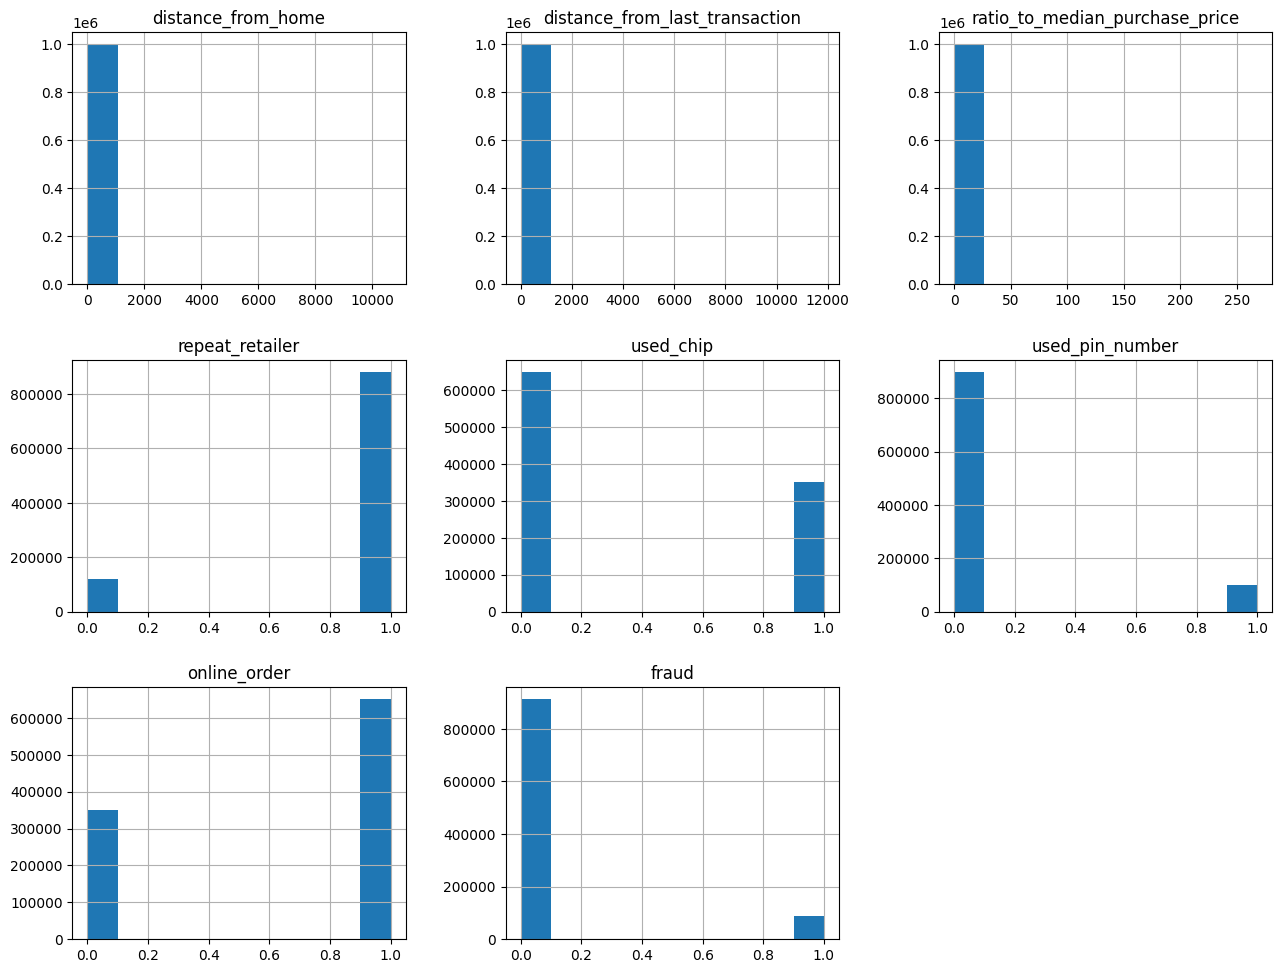

In [81]:
plt.figure(figsize=(24, 16)) 
df.hist()

plt.subplots_adjust(right=2, top=2)
plt.show()

# for col in df.columns:
#     plt.figure(figsize=(12, 8)) 
#     df.boxplot(column=col)
# plt.plot()

### Distributions

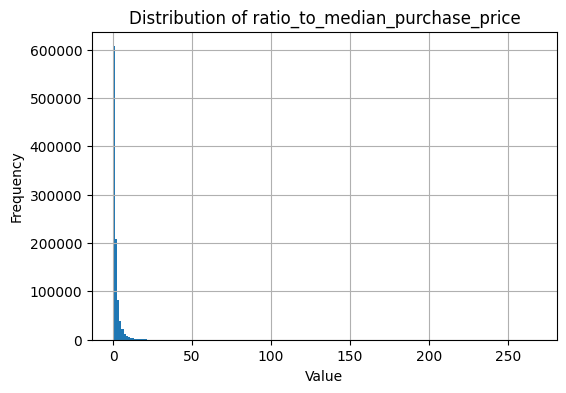

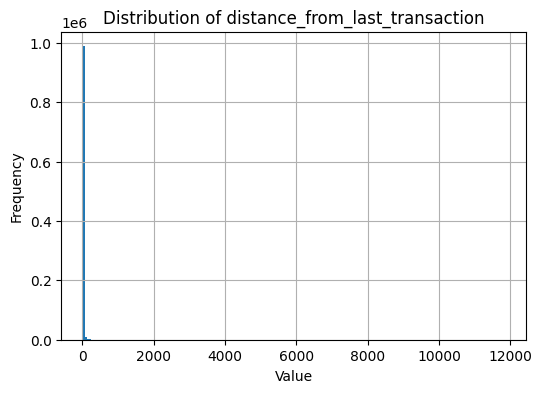

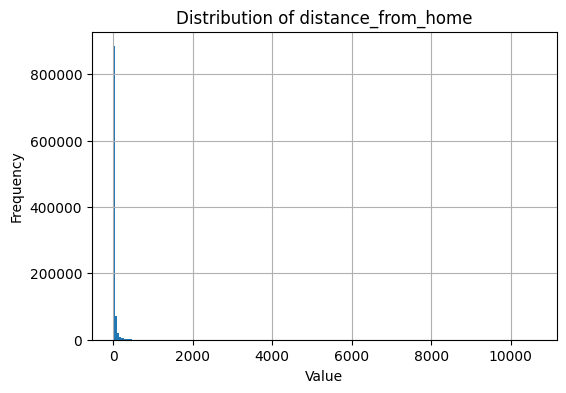

In [82]:
for col in ['ratio_to_median_purchase_price', 'distance_from_last_transaction', 'distance_from_home']:
    df[col].hist(bins=200, figsize=(6,4))
    plt.title(f'Distribution of {col}')
    plt.xlabel('Value')
    plt.ylabel('Frequency')
    plt.show()

### Visualization analysis
In our dataset, we anticipate a predominant number of response variables to be zero. To address this imbalance, we will employ a stratified split approach for dividing the dataset into training and testing sets. This technique will ensure that the proportions of zero and non-zero values are consistently maintained across both sets, accurately reflecting the distribution in the original dataset. This approach is essential for preserving the integrity and representativeness of our data, thereby ensuring more reliable and valid model training and evaluation

## Data Preprocessing


The provided code will divide the dataset into two distinct sets: a training set and a testing set. Specifically, 70% of the data will be allocated to the training set, while the remaining 30% will be designated for the testing set. This division ensures that a substantial portion of the dataset is used for model training, while still reserving a significant part for evaluating the model's performance.

In [83]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df.drop('fraud', axis=1), df['fraud'], test_size=0.3, stratify=df['fraud'])
print('training set proportion: ', len(X_train) / (len(df)))
print('testing set proportion: ', len(X_test) / (len(df)))

training set proportion:  0.7
testing set proportion:  0.3


Our analysis reveals that the columns __ratio_to_median_purchase_price__ and __distance_from_home__ exhibits a right-skewed distribution. This suggests that applying a log transformation could be beneficial to achieve a more normally distributed dataset. Furthermore, we observe that the columns __ratio_to_median_purchase_price__, __distance_from_last_transaction__, and __distance_from_home__ span a wide range of values, from 0 to 10,000. Neural networks are known not to perform will with values that have a large range. Therefore, we will employ a Standard Scaler as a preprocessing step to normalize these columns, ensuring that each feature contributes proportionately to the model's learning process.

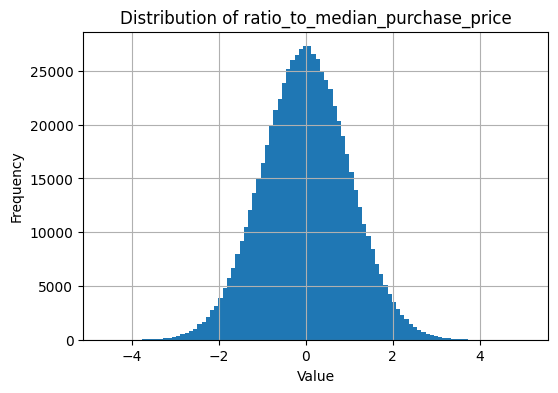

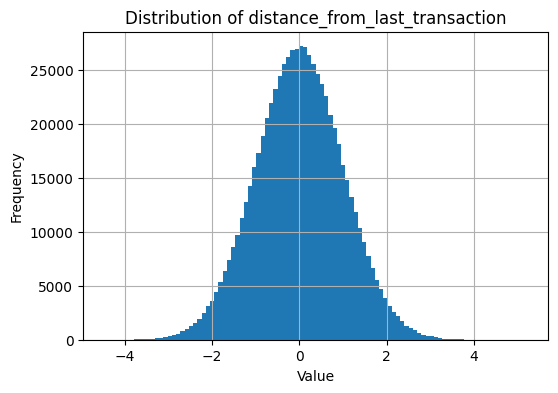

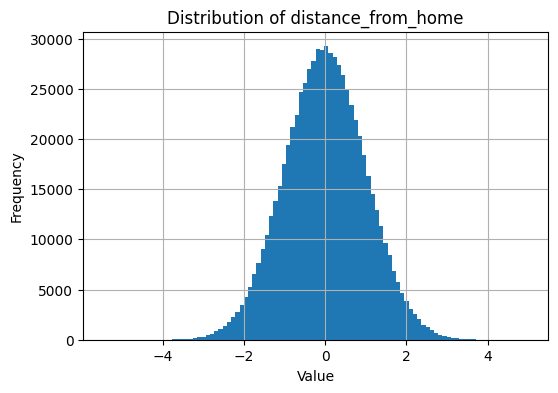

,distance_from_home,distance_from_last_transaction,ratio_to_median_purchase_price,repeat_retailer,used_chip,used_pin_number,online_order
665440,0.895863,1.090045,-2.280078,1.0,0.0,0.0,0.0
151078,-1.690666,1.996604,-0.541581,0.0,1.0,0.0,0.0
21765,-0.314449,-1.216538,-1.089809,1.0,1.0,1.0,1.0
225932,0.935032,1.379508,-0.022414,1.0,0.0,0.0,1.0
444213,-1.229298,0.941539,-1.586485,0.0,0.0,1.0,1.0
...,...,...,...,...,...,...,...
209344,-0.200387,-0.332762,0.454013,1.0,1.0,0.0,1.0
298423,-0.638477,-1.940441,-0.115069,1.0,0.0,0.0,1.0
669740,-2.472462,-0.665524,0.541308,0.0,0.0,0.0,1.0
698708,0.070204,-2.000237,0.408300,1.0,0.0,0.0,0.0


In [87]:
from sklearn.preprocessing import StandardScaler
from scipy.stats import boxcox
def data_preprocessing(X, show_hist=False):
    X = X.copy()
    cols = ['ratio_to_median_purchase_price', 'distance_from_last_transaction', 'distance_from_home']
    for i, col in enumerate(cols):
        # Adding an offset to the log tranformation to prevent taking the log of zero
        min_value = X[col].min()
        offset = 1 - min_value if min_value <= 0 else 0
        
        if col != 1:
            X[col] = np.log(X[col] + offset) 
        else:
            transformed_data, _ = boxcox(X[col] + offset) 
            X[col] = transformed_data
            
    for col in cols:
        scaler = StandardScaler()
        X[col] = scaler.fit_transform(X[[col]])

        if show_hist:
            X[col].hist(bins=100, figsize=(6, 4))
            plt.title(f'Distribution of {col}')
            plt.xlabel('Value')
            plt.ylabel('Frequency')
            plt.show()

    return X
data_preprocessing(X_train, True).describe()
